In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import os
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

img_size = 256
# channels = 4
train_size = 0.8
# img_shape = (channels, img_size, img_size)
batch_size = 55
n_epochs = 200
learning_rate_D = 1e-5
learning_rate_G = 1e-4

2024-07-29 13:45:19.043301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:45:19.043433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:45:19.186180: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cpu


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Define the Discriminator Model
class DModel(nn.Module):
    def __init__(self, block=ResidualBlock, all_connections=[3, 4, 6, 3]):
        super().__init__()
        self.inputs = 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer0 = self.makeLayer(block, 16, all_connections[0], stride=1)
        self.layer1 = self.makeLayer(block, 32, all_connections[1], stride=2)
        self.layer2 = self.makeLayer(block, 128, all_connections[2], stride=2)
        self.layer3 = self.makeLayer(block, 256, all_connections[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(256, 1)

    def makeLayer(self, block, outputs, connections, stride=1):
        downsample = None
        if stride != 1 or self.inputs != outputs:
            downsample = nn.Sequential(
                nn.Conv2d(self.inputs, outputs, kernel_size=1, stride=stride),
                nn.BatchNorm2d(outputs),
            )
        layers = [block(self.inputs, outputs, stride, downsample)]
        self.inputs = outputs
        for _ in range(1, connections):
            layers.append(block(self.inputs, outputs))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = self.fc(x).flatten()
        return torch.sigmoid(x)

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class GModel(nn.Module):
    def __init__(self):
        super(GModel, self).__init__()
        self.conv_1 = DoubleConv(4, 32)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_2 = DoubleConv(32, 64)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_3 = DoubleConv(64, 128)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_4 = DoubleConv(128, 256)
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_5 = DoubleConv(256, 512)

        self.upconv_1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_6 = DoubleConv(512, 256)

        self.upconv_2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_7 = DoubleConv(256, 128)

        self.upconv_3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_8 = DoubleConv(128, 64)

        self.upconv_4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv_9 = DoubleConv(64, 32)

        self.output = nn.Conv2d(32, 4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        conv_1_out = self.conv_1(x)
        conv_2_out = self.conv_2(self.pool_1(conv_1_out))
        conv_3_out = self.conv_3(self.pool_2(conv_2_out))
        conv_4_out = self.conv_4(self.pool_3(conv_3_out))
        conv_5_out = self.conv_5(self.pool_4(conv_4_out))

        upconv_1_out = self.upconv_1(conv_5_out)
        upconv_1_out = F.interpolate(upconv_1_out, size=(conv_4_out.size(2), conv_4_out.size(3)))
        conv_6_out = self.conv_6(torch.cat([upconv_1_out, conv_4_out], dim=1))

        upconv_2_out = self.upconv_2(conv_6_out)
        upconv_2_out = F.interpolate(upconv_2_out, size=(conv_3_out.size(2), conv_3_out.size(3)))
        conv_7_out = self.conv_7(torch.cat([upconv_2_out, conv_3_out], dim=1))

        upconv_3_out = self.upconv_3(conv_7_out)
        upconv_3_out = F.interpolate(upconv_3_out, size=(conv_2_out.size(2), conv_2_out.size(3)))
        conv_8_out = self.conv_8(torch.cat([upconv_3_out, conv_2_out], dim=1))

        upconv_4_out = self.upconv_4(conv_8_out)
        upconv_4_out = F.interpolate(upconv_4_out, size=(conv_1_out.size(2), conv_1_out.size(3)))
        conv_9_out = self.conv_9(torch.cat([upconv_4_out, conv_1_out], dim=1))

        output = self.output(conv_9_out)

        return torch.sigmoid(output)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, bg_path, no_bg_path, transform=None):
        self.bg_images = [os.path.join(bg_path, img) for img in os.listdir(bg_path)]
        self.no_bg_images = [os.path.join(no_bg_path, img) for img in os.listdir(no_bg_path)]
        self.transform = transform

    def __len__(self):
        return len(self.bg_images)

    def __getitem__(self, idx):
        bg_img = Image.open(self.bg_images[idx])
        no_bg_img = Image.open(self.no_bg_images[idx])

        if self.transform:
            bg_img = self.transform(bg_img)
            no_bg_img = self.transform(no_bg_img)

        return bg_img, no_bg_img

In [6]:
def show_fake_images(fake_imgs, num_images=3, figsize=(10, 10)):
    fake_imgs = fake_imgs.permute(0, 2, 3, 1).cpu().detach().numpy()
    num_images = min(num_images, fake_imgs.shape[0])
    fig, axs = plt.subplots(1, num_images, figsize=figsize)
    
    if num_images == 1:
        axs = [axs]

    for i in range(num_images):
        img = (fake_imgs[i] * 255).astype(np.uint8)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [7]:
def train_gan(train_loader, test_loader, generator, discriminator, optimizer_G, optimizer_D, bce, l1loss, 
              num_epochs, device='cuda', last_checkpoint_dir="models/last_checkpoint.pth"):
    writer = SummaryWriter('runs/gan_experiment')
    start_epoch = 0
    best_g_loss = float('inf')
    best_d_loss = float('inf')

    if os.path.exists(last_checkpoint_dir):
        checkpoint = torch.load(last_checkpoint_dir, map_location=device)
        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_d_loss = checkpoint['best_d_loss']
        best_g_loss = checkpoint['best_g_loss']
        print("Đã tải mô hình last và tiếp tục huấn luyện từ epoch", start_epoch)
    else:
        print("Không tìm thấy mô hình last, bắt đầu huấn luyện lại từ đầu")

    os.makedirs("models", exist_ok=True)

#     scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, 'min', factor=0.5, patience=10, 
#                                                        verbose=True, threshold=1e-4)
#     scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, 'min', factor=0.5, patience=10, 
#                                                        verbose=True, threshold=1e-4)

    for epoch in range(start_epoch, num_epochs):
        discriminator.train()
        generator.train()

        discriminator_epoch_loss, generator_epoch_loss = 0, 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, true_images = inputs.to(device), targets.to(device)

            ###### Train D Model
            optimizer_D.zero_grad()

            fake_images = generator(inputs)

            # Predict Fake/Real from D_model with fake image (hope will return 0) and count loss
            pred_fake = discriminator(fake_images).to(device)
            loss_fake = bce(pred_fake, torch.zeros_like(pred_fake, device=device))

            # Predict Fake/Real from D_model with real image (hope will return 1) and count loss
            pred_real = discriminator(true_images).to(device)
            loss_real = bce(pred_real, torch.ones_like(pred_real, device=device))

            loss_D = (loss_fake + loss_real) / 2

            loss_D.backward()
            optimizer_D.step()

            discriminator_epoch_loss += loss_D.item()

            ###### Train G Model
            optimizer_G.zero_grad()

            fake_images = generator(inputs)

            # Predict fake/real from D_model, calculate loss D_Model
            pred_fake = discriminator(fake_images).to(device)
            loss_G_bce = bce(pred_fake, torch.ones_like(pred_fake, device=device))

            # Calculate L1 loss, MAE between fake image and targets
            loss_G_l1 = l1loss(fake_images, true_images) * 100

            loss_G = loss_G_bce + loss_G_l1

            loss_G.backward()
            optimizer_G.step()

            generator_epoch_loss += loss_G.item()
            
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

        discriminator_epoch_loss /= len(train_loader)
        generator_epoch_loss /= len(train_loader)

        print(f"Epoch [{epoch}/{num_epochs}], D Loss: {discriminator_epoch_loss:.4f}, G Loss: {generator_epoch_loss:.4f}")

        discriminator.eval()
        generator.eval()

        discriminator_epoch_val_loss, generator_epoch_val_loss = 0, 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                fake_images = generator(inputs).detach()
                pred_fake = discriminator(fake_images).to(device)

                loss_G_bce = bce(pred_fake, torch.ones_like(pred_fake, device=device))
                loss_G_l1 = l1loss(fake_images, targets) * 100
                loss_G = loss_G_bce + loss_G_l1
                loss_D = bce(pred_fake.to(device), torch.zeros_like(pred_fake, device=device))

                discriminator_epoch_val_loss += loss_D.item()
                generator_epoch_val_loss += loss_G.item()

        discriminator_epoch_val_loss /= len(test_loader)
        generator_epoch_val_loss /= len(test_loader)

        print(f"Validation Epoch [{epoch}/{num_epochs}] - D Loss: {discriminator_epoch_val_loss:.4f}, G Loss: {generator_epoch_val_loss:.4f}")

        if discriminator_epoch_loss < best_d_loss:
            best_d_loss = discriminator_epoch_loss
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'epoch': epoch,
                'best_g_loss': best_g_loss,
                'best_d_loss': best_d_loss
            }, "models/best_d_checkpoint.pth")

        if generator_epoch_loss < best_g_loss:
            best_g_loss = generator_epoch_loss
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'epoch': epoch,
                'best_g_loss': best_g_loss,
                'best_d_loss': best_d_loss
            }, "models/best_g_checkpoint.pth")

#         scheduler_G.step(generator_epoch_loss)
#         scheduler_D.step(discriminator_epoch_loss)

        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'epoch': epoch,
            'best_g_loss': best_g_loss,
            'best_d_loss': best_d_loss
        }, last_checkpoint_dir)

        print(f"Saved last model after epoch {epoch}")
        print(f"Generated sample image at epoch {epoch}")
        show_fake_images(fake_images.cpu())
        print("------------------------------------------")

    torch.save({
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'epoch': num_epochs - 1,
        'best_g_loss': best_g_loss,
        'best_d_loss': best_d_loss
    }, "models/final_checkpoint.pth")
    print("Saved final model after training ended")

In [8]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

bg_path = '/kaggle/input/images-with-no-background-for-background-removal/dataset/in'
no_bg_path = '/kaggle/input/images-with-no-background-for-background-removal/dataset/out'
dataset = CustomDataset(bg_path, no_bg_path, transform)

dataset = CustomDataset(bg_path, no_bg_path, transform)
train_count = int(train_size * len(dataset))
test_count = len(dataset) - train_count
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_count, test_count])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Batch size: 55
Image shape: torch.Size([55, 4, 256, 256])


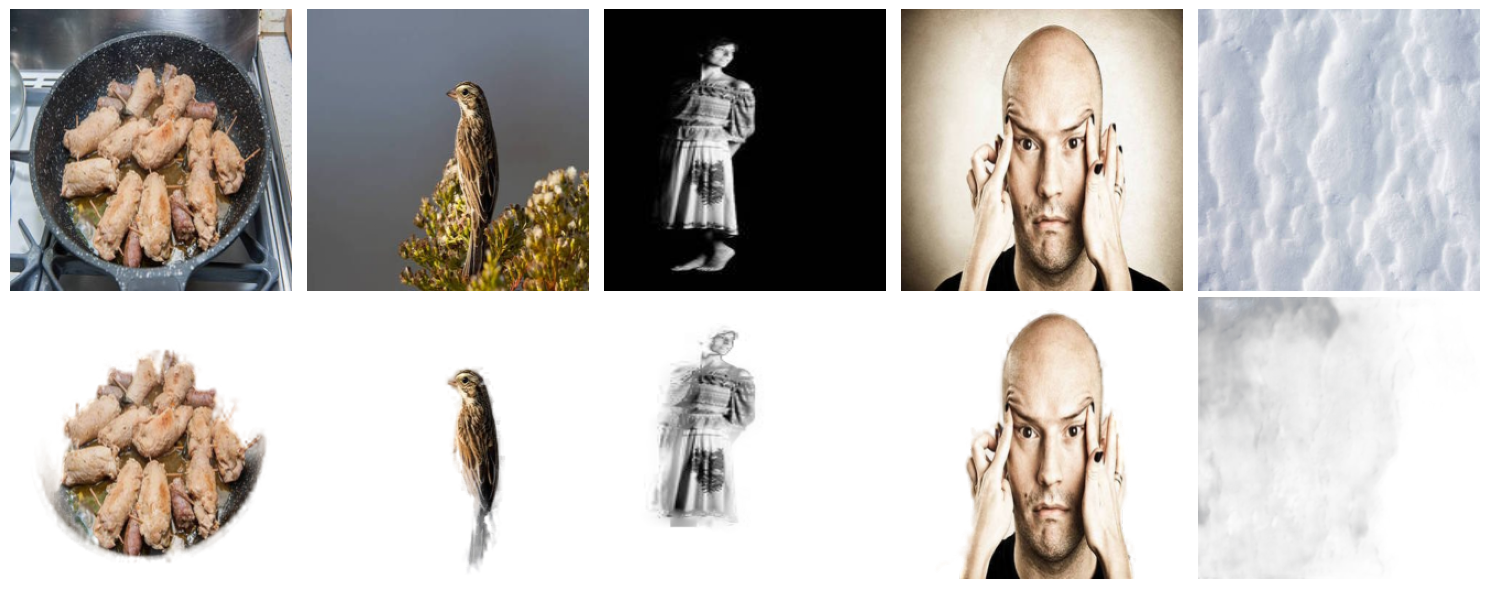

In [9]:
import matplotlib.pyplot as plt

for bg_imgs, no_bg_imgs in train_loader:
    print(f"Batch size: {bg_imgs.size(0)}")
    print(f"Image shape: {no_bg_imgs.shape}")

    num_display = min(5, bg_imgs.size(0))
    
    fig, axes = plt.subplots(2, num_display, figsize=(15, 6))
    for i in range(num_display):
        img = bg_imgs[i].permute(1, 2, 0).detach().cpu().numpy()
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
    
    for i in range(num_display):
        img = no_bg_imgs[i].permute(1, 2, 0).detach().cpu().numpy()
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    break

In [ ]:
generator = GModel().to(device)
discriminator = DModel().to(device)

bce = nn.BCEWithLogitsLoss()
l1loss = nn.L1Loss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G)

train_gan(train_loader, test_loader, generator, discriminator, optimizer_G, optimizer_D, bce, 
          l1loss, num_epochs=n_epochs, device=device)

Không tìm thấy mô hình last, bắt đầu huấn luyện lại từ đầu


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import io
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_test = GModel().to(device)

img_test_size = 512
checkpoint_path = "/kaggle/input/gan_last/pytorch/default/2/last_checkpoint (6).pth"

checkpoint = torch.load(checkpoint_path, map_location=device)
generator_test.load_state_dict(checkpoint['generator'])
generator_test.eval()

def convert_to_png(image_path):
    with Image.open(image_path) as img:
        if img.format != 'PNG':
            img = img.convert('RGBA')
            buffer = io.BytesIO()
            img.save(buffer, format='PNG')
            buffer.seek(0)
            return Image.open(buffer)
        else:
            return Image.open(image_path)


transform = transforms.Compose([
#     transforms.Resize((img_test_size, img_test_size)),
    transforms.ToTensor()
])

def process_and_generate(image_path, output_path):
    input_img = convert_to_png(image_path)
    
    input_img = transform(input_img).unsqueeze(0)

    with torch.no_grad():
        input_img = input_img.to(device)
        fake_img = generator_test(input_img)
        fake_img = fake_img.squeeze().cpu()

    fake_img_pil = transforms.ToPILImage()(fake_img)
    fake_img_pil.save(output_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(transforms.ToPILImage()(input_img.squeeze()))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(fake_img_pil)
    axs[1].set_title('Generated Image')
    axs[1].axis('off')

    plt.show()

# input_image_path = "/kaggle/input/1041.png"
input_image_path = "/kaggle/input/images-with-no-background-for-background-removal/dataset/in/1029.png"
output_image_path = "generated_image.png"

process_and_generate(input_image_path, output_image_path)

In [ ]:
def show_images(images, titles=None, ncols=5):
    n_images = len(images)
    fig, axes = plt.subplots(nrows=(n_images + ncols - 1) // ncols, ncols=ncols, figsize=(15, 15))
    axes = axes.flatten()
    for i, img in enumerate(images):
        ax = axes[i]
        ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    for ax in axes[n_images:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def predict_and_compare(test_loader, n_images=10):
    data_iter = iter(test_loader)
    images_with_bg, images_without_bg = next(data_iter)

    if n_images > len(images_with_bg):
        n_images = len(images_with_bg)

    images_with_bg = images_with_bg[:n_images]
    images_without_bg = images_without_bg[:n_images]

    with torch.no_grad():
        images_with_bg = images_with_bg.to(device)
        fake_images = generator(images_with_bg)
        fake_images = fake_images.cpu()

    transform_to_pil = transforms.ToPILImage()
    images_with_bg_pil = [transform_to_pil(img) for img in images_with_bg]
    fake_images_pil = [transform_to_pil(img) for img in fake_images]
    images_without_bg_pil = [transform_to_pil(img) for img in images_without_bg]

    show_images(images_with_bg_pil, titles=[f"BG Image {i+1}" for i in range(n_images)])
    show_images(fake_images_pil, titles=[f"Predicted {i+1}" for i in range(n_images)])
    show_images(images_without_bg_pil, titles=[f"Real No BG {i+1}" for i in range(n_images)])

predict_and_compare(test_loader, n_images=5)